# makemore, but made with an MLP (Multi-Layer Perceptron)


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    torch.set_default_device(mps_device)

In [3]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]  # show first 8 words

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)  # how many words do we have?

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))  # unique characters in the words
stoi = {s: i + 1 for i, s in enumerate(chars)}  # string to integer mapping
stoi["."] = 0  # add a special end-of-word character
itos = {i: s for s, i in stoi.items()}  # integer to string mapping
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Buiding the dataset


In [6]:
block_size = (
    3  # Context length: how many characters do we take to predict the next character?
)
X, Y = [], []  # input and output arrays
for w in words:
    # print(f'word: {w}')
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]  # convert character to integer
        X.append(context)  # append the context
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix]  # slide the window, add new character

X = torch.tensor(X)  # convert to tensor
Y = torch.tensor(Y)  # convert to tensor

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
# Lookup Table
C = torch.randn((27, 2))

In [9]:
emb = C[X]
emb.shape  # shape of the embedding tensor

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6, 100))  # weights for the first layer
b1 = torch.randn(100)  # bias for the first layer

In [11]:
# torch.cat(torch.unbind(emb, 1), dim=1).shape
h = torch.tanh(
    emb.view(emb.shape[0], -1) @ W1 + b1
)  # apply linear transformation and activation

In [12]:
h

tensor([[ 0.6741,  0.0674, -0.9397,  ..., -0.8416, -0.0402,  0.9537],
        [ 0.5190,  0.1527, -0.9005,  ...,  0.1187,  0.2137,  0.9281],
        [ 0.9078,  0.2268, -0.9622,  ..., -0.8567, -0.4530,  0.9229],
        ...,
        [-0.8957,  0.9927,  0.6507,  ..., -0.0046,  0.9870,  0.2529],
        [-0.9895,  0.9915,  0.9470,  ...,  0.9999,  0.9975, -0.1311],
        [-0.9311,  0.7202,  0.7659,  ...,  0.9648,  0.9999,  0.1708]],
       device='mps:0')

In [13]:
h.shape

torch.Size([228146, 100])

In [14]:
W2 = torch.randn((100, 27))  # weights for the output layer
b2 = torch.randn(27)  # bias for the output layer

In [15]:
logits = h @ W2 + b2  # compute logits for the output layer

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()  # convert logits to counts (unnormalized probabilities)

In [18]:
prob = counts / counts.sum(1, keepdim=True)  # normalize to get probabilities

In [19]:
prob.shape

torch.Size([228146, 27])

In [20]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [115]:
g = torch.Generator(device=mps_device).manual_seed(
    2147483647
)  # set random seed for reproducibility
C = torch.randn(
    (27, 2), generator=g
)  # reinitialize the lookup table with the same seed
W1 = torch.randn((6, 100), generator=g)  # reinitialize weights
b1 = torch.randn(100, generator=g)  # reinitialize biases for the first layer
W2 = torch.randn((100, 27), generator=g)  # reinitialize weights for the output layer
b2 = torch.randn(27, generator=g)  # reinitialize biases for the output layer
parameters = [C, W1, b1, W2, b2]  # list of parameters

In [116]:
sum(p.nelement() for p in parameters)

3481

In [117]:
for p in parameters:
    p.requires_grad = True  # enable gradients for all parameters

In [118]:
# Exponentially linearly spaced learning rates
steps = 10000
# lre = torch.linspace(-3, 0, steps)
lre = torch.linspace(-1.75, -0.25, steps)
lrs = 10**lre

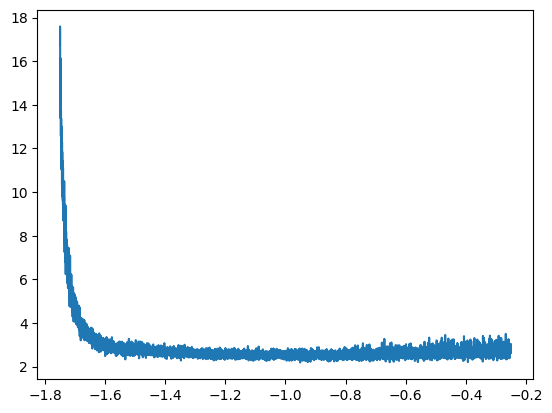

In [119]:
#  Forward pass
X, Y = X.to(mps_device), Y.to(mps_device)  # move
# learning_rate = -0.25  # learning rate for the optimizer
lri = []
lossi = []

for i in range(steps):
    # Construct Mini-batch
    ix = torch.randint(0, X.shape[0], (128,))

    emb = C[X[ix]]  # get embeddings for the input characters
    h = torch.tanh(
        emb.view(emb.shape[0], -1) @ W1 + b1
    )  # apply linear transformation and activation
    logits = h @ W2 + b2  # compute logits for the output layer
    # counts = logits.exp()  # convert logits to counts (unnormalized probabilities)
    # prob = counts / counts.sum(1, keepdim=True)  # normalize to get probabilities
    # loss = -prob[torch.arange(32), Y].log().mean()  # compute the log probability of the true labels
    loss = F.cross_entropy(
        logits, Y[ix]
    )  # equivalent loss using PyTorch's built-in function

    # Backward pass
    for p in parameters:
        p.grad = None  # zero out gradients

    loss.backward()  # compute gradients
    # Update parameters
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad  # update parameters using gradient descent

    # Track stats
    lri.append(lre[i].cpu())
    lossi.append(loss.item())

# print(loss.item())  # print the loss value
plt.plot(lri, lossi)

In [81]:
emb = C[X]  # get embeddings for the input characters
h = torch.tanh(
    emb.view(emb.shape[0], -1) @ W1 + b1
)  # apply linear transformation and activation
logits = h @ W2 + b2  # compute logits for the output layer
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5764, device='mps:0', grad_fn=<NllLossBackward0>)

### Training the model on the entirety of the data for all passes will lead to a very large training time, so we will use batches of data for training

It is generally better to train smaller batches of data though the gradient is not as accurate, but its better to take many small steps than a few large steps.
